In [24]:
%load_ext autoreload
%autoreload 2
from naplab import parse_camera_json, filter_cameras, better_process_data, NaplabDataset
from utils import plot_coordinates, plot_directions
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
cameraList = parse_camera_json("./Trip094/camerasandCanandGnssCalibratedAll_lidars00-virtual.json")
c3_120 = filter_cameras(cameraList, ["C3_tricam120"])[0]
c5_r1, c7_l2 = filter_cameras(cameraList, ["C5_R1", "C7_L2"])
c5_ts = c5_r1.timestamps
data = better_process_data("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt", c5_ts) # gps points for c5_r1 camera
#data = process_frame("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt")
cameraList

[Camera(C1_front60Single),
 Camera(C2_tricam60),
 Camera(C3_tricam120),
 Camera(C4_rearCam),
 Camera(C5_R1),
 Camera(C6_L1),
 Camera(C7_L2),
 Camera(C8_R2)]

In [26]:
# Note that the x-axis is for forwards and backwards while the y-axis is for left/right,
#print(c7_l2.translation)
#print(c5_r1.translation)
c5_r1.get_camera_intrinsics()#, c5_r1.video_path, c5_r1.timestamps

{'camera_model': 'OPENCV_FISHEYE',
 'fl_x': 1662.7687752661227,
 'fl_y': 1046.1586877716022,
 'cx': 965.822693,
 'cy': 649.506042,
 'w': 1920,
 'h': 1208,
 'k1': 0.9165923647458017,
 'k2': -0.05700684388075289,
 'k3': 0.016865157086270094,
 'k4': -0.004610156570632181,
 'p1': 0,
 'p2': 0}

In [27]:
c5_r1.get_colmap_camera_description()

'4 OPENCV_FISHEYE 1920 1208 1662.7688 1046.1587  965.8227 649.5060 0.916592 -0.057007 0.016865 -0.004610'

In [28]:
for camera in cameraList:
    print(camera.get_colmap_camera_description())

0 OPENCV_FISHEYE 1920 1208 1662.7688 1046.1587  846.8632 670.6655 1.774553 -0.085525 0.567620 -0.868383
1 OPENCV_FISHEYE 1920 1208 1662.7688 1046.1587 1187.2672 632.1146 1.812940 -0.047013 0.297529 -0.346682


KeyboardInterrupt: 

In [ ]:
# test the translation and rotation matrix
epsilon = 0.0001
points = [frame.center for frame in data]

points_from_translation_matrix = [frame.get_translation_matrix() @ np.array([0,0,0,1]) for frame in data]
diffs = np.stack(points) - np.stack(points_from_translation_matrix)
max_error = np.max(diffs)

if max_error > epsilon:
    raise Exception("Car translation matrix broken")

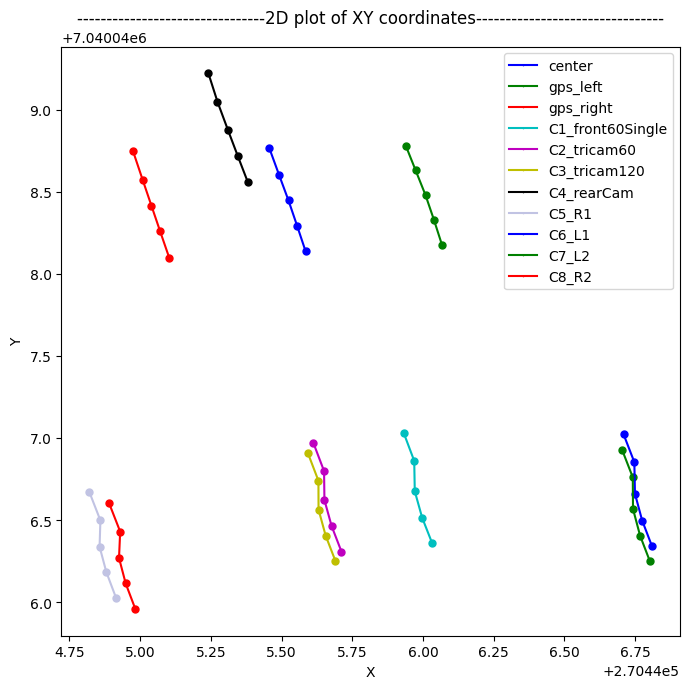

In [ ]:
max_index = 5

gps_left = [frame.left_point for frame in data]
gps_right = [frame.right_point for frame in data]
center = [frame.center for frame in data[:max_index]]

cam1_pos = [c5_r1.get_camera_position(frame) for frame in data[:max_index]]
cam2_pos = [c7_l2.get_camera_position(frame) for frame in data[:max_index]]

cam_positions = []
for camera in cameraList:
    cam_positions.append([camera.get_camera_position(frame) for frame in data[:max_index]])

#cam_positions = [camera.get_camera_position(frame) for frame in data[:max_index] for camera in cameraList]
#print(cam_positions[0])
cam_labels = [camera.description for camera in cameraList]

plot_coordinates([center[:max_index], gps_left[:max_index], gps_right[:max_index], *cam_positions], 
        labels=["center", "gps_left", "gps_right", *cam_labels], figsize=(7, 7), is3D=False)
#plot_coordinates([center[:max_index], gps_left[:max_index], gps_right[:max_index]], 
#        labels=["center", "gps_left", "gps_right"], figsize=(7, 7), is3D=False)
#plot_coordinates([center[:max_index], gps_left[:max_index], gps_right[:max_index]], 
#        labels=["center", "gps_left", "gps_right"], figsize=(7, 7), is3D=False)



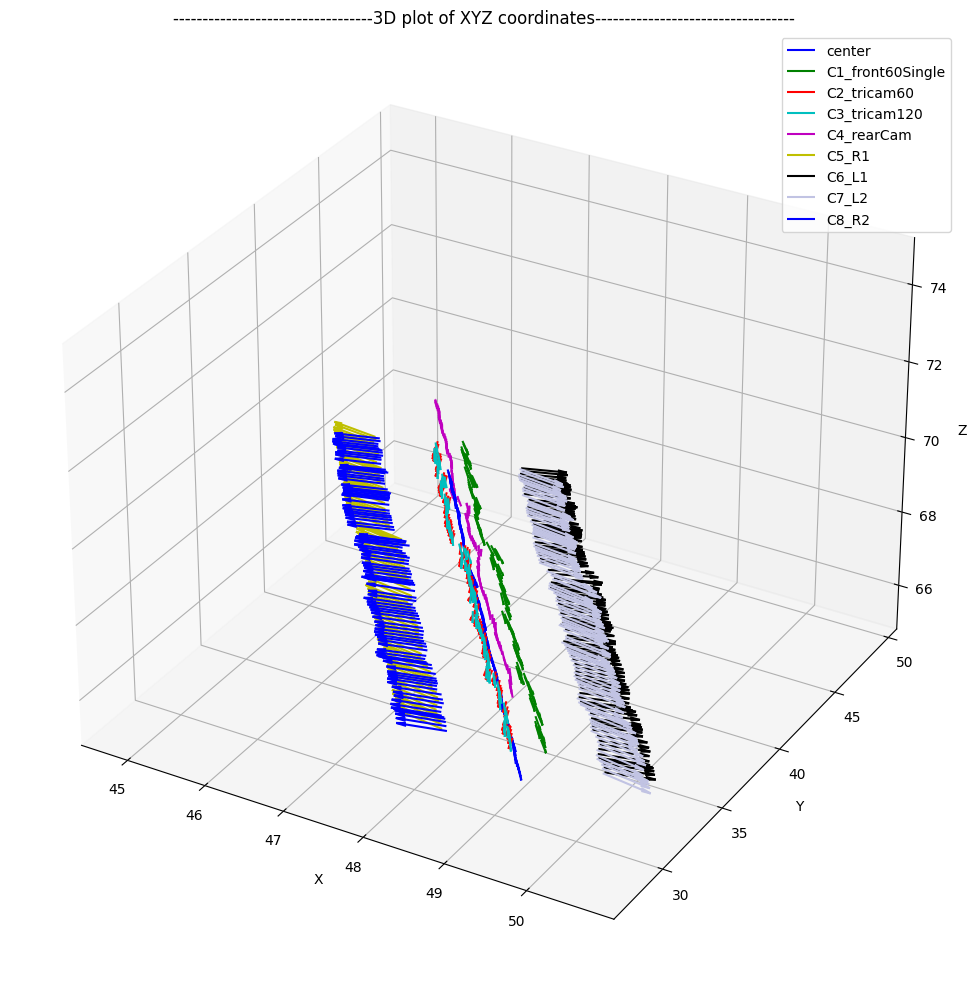

In [ ]:
min_index = 0
max_index = 100
center = [frame.center for frame in data[min_index:max_index]]
cardir = [frame.get_rotation_matrix() @ np.array([1,0,0,1]) for frame in data][min_index:max_index]
cardir2 = [frame.forward for frame in data][min_index:max_index]
carup = [frame.up for frame in data[min_index:max_index]]
dir1 = [c5_r1.get_camera_direction_vector(frame) for frame in data][min_index:max_index]
dir2 = [c7_l2.get_camera_direction_vector(frame) for frame in data][min_index:max_index]

cam_dirs = []
for camera in cameraList:
    cam_dirs.append([camera.get_camera_direction_vector(frame) for frame in data[min_index:max_index]])

cam_positions = []
for camera in cameraList:
    cam_positions.append([camera.get_camera_position(frame) for frame in data[min_index:max_index]])

cam_labels = [camera.description for camera in cameraList]

cam1_pos = [c5_r1.get_camera_position(frame) for frame in data[min_index:max_index]]
cam2_pos = [c7_l2.get_camera_position(frame) for frame in data[min_index:max_index]]

directions = [cardir, *cam_dirs]
#directions = [cardir, carup]
positions = [center, *cam_positions]
#positions = [center, center]
labels = ["center", *cam_labels]
plot_directions(positions, directions, labels, figsize=(10, 10), is3D=True)


In [ ]:
nap = NaplabDataset("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt", fps=2, rig_json_path="./Trip094/nobadcam.json", n = 30)
nap.create_nerfstudio_dataset("nerfstudio")
#nap.create_colmap_dataset("colmap")

Cam 0 | Image Saving Batch 0 completed
Cam 1 | Image Saving Batch 0 completed
Cam 2 | Image Saving Batch 0 completed
Transforms JSON created at nerfstudio/transforms.json


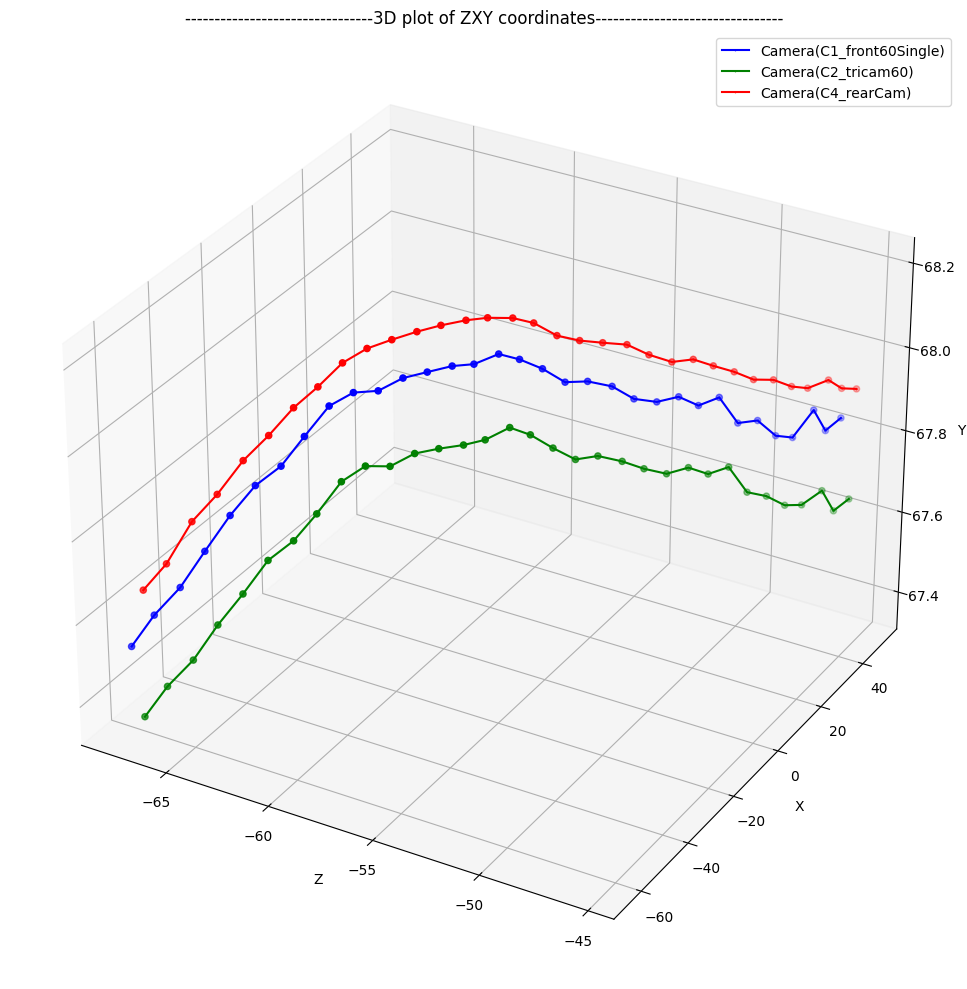

In [ ]:
nap.plot_blender_coordinates(figsize=(10,10), is3D=True)

In [ ]:
awt = nap.all_images_with_transforms
cam0 = awt[0].camera
cam0.create_car_mask()

In [ ]:
import hloc

# HLOC experimentation

In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_retrieval,
    pairs_from_exhaustive
)
from hloc import colmap_from_nvm, triangulation, localize_sfm, visualization
import pycolmap
from pycolmap import (
    Reconstruction
)
from hloc.utils import viz_3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
nap = NaplabDataset("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt", fps=5, n = 20)
nap.create_nerfstudio_dataset("nerfstudio")

Cam 0 | Image Saving Batch 0 completed
Cam 1 | Image Saving Batch 0 completed
Cam 2 | Image Saving Batch 0 completed
Cam 3 | Image Saving Batch 0 completed
Cam 4 | Image Saving Batch 0 completed
Cam 5 | Image Saving Batch 0 completed
Cam 6 | Image Saving Batch 0 completed
Cam 7 | Image Saving Batch 0 completed
Transforms JSON created at nerfstudio/transforms.json


In [126]:
images = Path("nerfstudio/images")
outputs = Path("outputs/sfm/")
sfm_pairs = outputs / "pairs-netvlad.txt"
sfm_dir = outputs / "sfm_superpoint+superglue"
database = sfm_dir / "database.db"

retrieval_conf = extract_features.confs["netvlad"]
feature_conf = extract_features.confs["superpoint_aachen"]
matcher_conf = match_features.confs["superglue"]

In [127]:
retrieval_path = extract_features.main(retrieval_conf, images, outputs, as_half=False)
pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=5)
feature_path = extract_features.main(feature_conf, images, outputs, as_half=False)
match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2024/05/14 20:26:57 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/05/14 20:26:57 hloc INFO] Found 192 images in root nerfstudio/images.


100%|██████████| 192/192 [00:14<00:00, 13.50it/s]
[2024/05/14 20:27:19 hloc INFO] Finished exporting features.
[2024/05/14 20:27:19 hloc INFO] Extracting image pairs from a retrieval database.
[2024/05/14 20:27:19 hloc INFO] Found 960 pairs.
[2024/05/14 20:27:19 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2024/05/14 20:27:19 hloc INFO] Found 192 images in root nerfstudio/images.


Loaded SuperPoint model


100%|██████████| 192/192 [00:09<00:00, 19.92it/s]
[2024/05/14 20:27:29 hloc INFO] Finished exporting features.
[2024/05/14 20:27:29 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 554/554 [00:49<00:00, 11.08it/s]
[2024/05/14 20:28:19 hloc INFO] Finished exporting matches.


In [128]:
import os
import hloc.reconstruction
from database import COLMAPDatabase

os.makedirs(sfm_dir, exist_ok=True)
hloc.reconstruction.create_empty_db(database)
db = COLMAPDatabase.connect(database)
for cam in nap.cameras:
    k1, k2, k3, k4 = cam.calculate_distortion_coeff()
    db.add_camera(5, cam.width, cam.height, [cam.fx, cam.fy, cam.cx, cam.cy, k1, k2, k3, k4], camera_id=cam.id)
for it in nap.all_images_with_transforms:
    cam = it.camera
    for frame, image_transform in zip(it.frames, it.images_with_transforms):
        name = Path(image_transform.image_path).name
        db.add_image(name, cam.id, cam.get_quaternion(frame), cam.get_translation_vector(frame))
db.commit()
db.close()
#hloc.reconstruction.import_images(images, database, pycolmap.CameraMode.AUTO)
image_ids = hloc.reconstruction.get_image_ids(database)
print(image_ids)

[2024/05/14 20:28:19 hloc INFO] Creating an empty database...


{'0_104.png': 8, '0_109.png': 9, '0_114.png': 10, '0_119.png': 11, '0_124.png': 12, '0_129.png': 13, '0_134.png': 14, '0_139.png': 15, '0_144.png': 16, '0_149.png': 17, '0_154.png': 18, '0_159.png': 19, '0_164.png': 20, '0_169.png': 21, '0_174.png': 22, '0_179.png': 23, '0_184.png': 24, '0_69.png': 1, '0_74.png': 2, '0_79.png': 3, '0_84.png': 4, '0_89.png': 5, '0_94.png': 6, '0_99.png': 7, '1_101.png': 33, '1_106.png': 34, '1_111.png': 35, '1_116.png': 36, '1_121.png': 37, '1_126.png': 38, '1_131.png': 39, '1_136.png': 40, '1_141.png': 41, '1_146.png': 42, '1_151.png': 43, '1_156.png': 44, '1_161.png': 45, '1_166.png': 46, '1_171.png': 47, '1_176.png': 48, '1_61.png': 25, '1_66.png': 26, '1_71.png': 27, '1_76.png': 28, '1_81.png': 29, '1_86.png': 30, '1_91.png': 31, '1_96.png': 32, '2_104.png': 59, '2_109.png': 60, '2_114.png': 61, '2_119.png': 62, '2_124.png': 63, '2_129.png': 64, '2_134.png': 65, '2_139.png': 66, '2_144.png': 67, '2_149.png': 68, '2_154.png': 69, '2_159.png': 70, '2_

In [129]:
print(match_path)
print(sfm_pairs)
print(feature_path)

outputs/sfm/feats-superpoint-n4096-r1024_matches-superglue_pairs-netvlad.h5
outputs/sfm/pairs-netvlad.txt
outputs/sfm/feats-superpoint-n4096-r1024.h5


In [130]:
import hloc.reconstruction
import hloc.triangulation
hloc.reconstruction.import_images(images, database, pycolmap.CameraMode.AUTO)
hloc.triangulation.import_features(image_ids, database, feature_path)
hloc.triangulation.import_matches(
        image_ids,
        database,
        sfm_pairs,
        match_path,
    )


[2024/05/14 20:28:19 hloc INFO] Importing images into the database...


[2024/05/14 20:28:27 hloc INFO] Importing features into the database...
100%|██████████| 192/192 [00:00<00:00, 1332.86it/s]
[2024/05/14 20:28:28 hloc INFO] Importing matches into the database...
100%|██████████| 960/960 [00:00<00:00, 1852.19it/s]


In [144]:
rec = pycolmap.Reconstruction()
for it in nap.all_images_with_transforms:
    rec.add_camera(it.camera.get_colmap_camera())
    for frame, image_transform in zip(it.frames, it.images_with_transforms):
        r3d = it.camera.get_rigid_3d(frame)
        name = Path(image_transform.image_path).name
        im = pycolmap.Image(name, [], r3d, it.camera.id, image_ids[name])
        rec.add_image(im)
        rec.register_image(image_ids[name])
#print(rec.summary())
rec.normalize()
rec.write_text(sfm_dir)
rec.write(sfm_dir)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, rec, color='rgba(255,0,0,0.5)', name="mapping", points=False)
fig.show()

In [132]:
import hloc.reconstruction


reconstruction = hloc.reconstruction.run_reconstruction(sfm_dir, database, images)

[2024/05/14 20:28:29 hloc INFO] Running 3D reconstruction...
I20240514 20:28:29.377184 531816 incremental_mapper.cc:225] Loading database
I20240514 20:28:29.378098 531816 database_cache.cc:65] Loading cameras...
I20240514 20:28:29.378144 531816 database_cache.cc:75]  8 in 0.000s
I20240514 20:28:29.378158 531816 database_cache.cc:83] Loading matches...
I20240514 20:28:29.378170 531816 database_cache.cc:89]  0 in 0.000s
I20240514 20:28:29.378180 531816 database_cache.cc:105] Loading images...
I20240514 20:28:29.378367 531816 database_cache.cc:155]  192 in 0.000s (connected 0)
I20240514 20:28:29.378381 531816 database_cache.cc:166] Building correspondence graph...
I20240514 20:28:29.378386 531816 database_cache.cc:203]  in 0.000s (ignored 0)
I20240514 20:28:29.378401 531816 timer.cc:91] Elapsed time: 0.000 [minutes]
W20240514 20:28:29.378410 531816 incremental_mapper.cc:247] No images with matches found in the database
[2024/05/14 20:28:29 hloc ERROR] Could not reconstruct any model!


In [133]:
help(pycolmap.Reconstruction)

Help on class Reconstruction in module pycolmap:

class Reconstruction(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      Reconstruction
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __copy__(...)
 |      __copy__(self: pycolmap.Reconstruction) -> pycolmap.Reconstruction
 |  
 |  __deepcopy__(...)
 |      __deepcopy__(self: pycolmap.Reconstruction, arg0: dict) -> pycolmap.Reconstruction
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: pycolmap.Reconstruction) -> None
 |      
 |      2. __init__(self: pycolmap.Reconstruction, sfm_dir: str) -> None
 |  
 |  __repr__(...)
 |      __repr__(self: pycolmap.Reconstruction) -> str
 |  
 |  add_camera(...)
 |      add_camera(self: pycolmap.Reconstruction, camera: pycolmap.Camera) -> None
 |      
 |      Add new camera. There is only one camera per image, while multiple images
 |      might be

In [134]:
help(pycolmap.Image)

Help on class Image in module pycolmap:

class Image(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      Image
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __copy__(...)
 |      __copy__(self: pycolmap.Image) -> pycolmap.Image
 |  
 |  __deepcopy__(...)
 |      __deepcopy__(self: pycolmap.Image, arg0: dict) -> pycolmap.Image
 |  
 |  __getstate__(...)
 |      __getstate__(self: pycolmap.Image) -> dict
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: pycolmap.Image) -> None
 |      
 |      2. __init__(self: pycolmap.Image, name: str = '', points2D: list[colmap::Point2D] = [], cam_from_world: pycolmap.Rigid3d = Rigid3d(quat_xyzw=[0, 0, 0, 1], t=[0, 0, 0]), camera_id: int = 4294967295, id: int = 4294967295) -> None
 |      
 |      3. __init__(self: pycolmap.Image, name: str = '', keypoints: list[numpy.ndarray[numpy.float64[2, 1]]] = [],